In [3]:
from Gridworld import Gridworld
# Existen 3 modos de juego:
# 'static' <-- Todo inicia en las mismas posiciones predeterminadas
# 'player' <-- Solo el jugador inicia en una posicion aleatoria
# 'random' <-- Todos los objetos inician de forma aleatoria
# size es el tamaño del tablero n x n
game = Gridworld(size=4, mode='static')

In [4]:
# Asi se puede mostrar graficamente el ambiente del juego
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [5]:
# Asi se hace una jugada 
# 'u' <--- arriba
# 'd' <--- abajo
# 'l' <--- izquierda
# 'r' <--- derecha
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [6]:
# Asi se muestra la recompensa obtenida
# + 10 por ganar '+'
# - 10 por caer al pozo '-'
# -1 por jugada sin ganar
# 'w' es un muro
game.reward()

-1

In [7]:
# Asi se representa el juego
# Cada matriz codifica la posición de uno de los cuatro objetos: 
# el jugador, la portería, el foso y el muro.
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [8]:
# Es un tensor de forma (4, 4, 4)
game.board.render_np().shape

(4, 4, 4)

In [32]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [33]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

In [475]:
epochs = 1000
losses = []
for i in range(epochs):  
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1, 64) \
             + np.random.rand(1, 64) / 10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while (status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1, 64) \
                  + np.random.rand(1, 64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1, 64))
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            status = 0
    if epsilon > 0.1:
        epsilon -= (1/epochs)

In [458]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True

def linear_model(x,m,b):
    y = m @ x + b
    return y 

y = linear_model(torch.Tensor([4.]), m, b)
y

tensor([9.], grad_fn=<AddBackward0>)

In [459]:
y.grad_fn

In [460]:
with torch.no_grad():
    y = linear_model(torch.Tensor([4]), m, b)
y

tensor([9.])

In [461]:
y.grad_fn

In [462]:
y = linear_model(torch.Tensor([4.]), m, b)
y.backward()
print(m.grad)
print(b.grad)

tensor([4.])
tensor([1.])


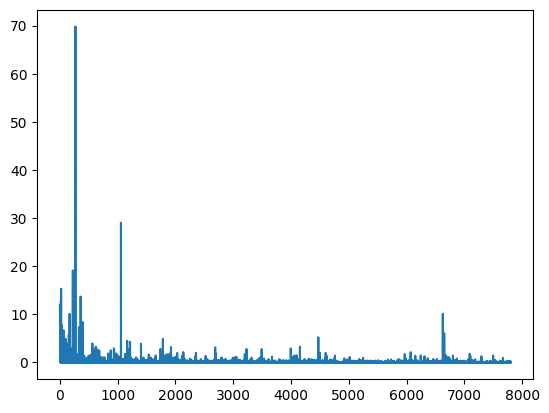

In [476]:
plt.plot(losses)